# CNN Baseline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image


## **Load glucose data**

In [ ]:
#!pip install -q xlrd
df = pd.read_excel('images-v1-dl-approxtimetake-glucosecgm-v2.xlsx')
df.head()

,...1,Folder,Filename,TimePhoneImage,TimeFilenameImage,TimeModifiedImage,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4
0,327,327,IMG_20190307_130615.jpg,2019-03-07 13:06:15,2019-03-07 13:06:15,2019-03-07 13:06:38,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,3.8,3.3,3.2,2.8,2.5,2.4,2.3,2.4,2.5,3.7,6.0,6.1,5.1
1,327,327,IMG_20190307_192048.jpg,2019-03-07 19:20:49,2019-03-07 19:20:48,2019-03-07 19:27:00,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,4.4,4.7,4.8,4.6,4.1,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9
2,327,327,IMG_20190307_204505.jpg,2019-03-07 20:45:06,2019-03-07 20:45:05,2019-03-07 22:01:25,-122.0,-107.0,-92.0,-77.0,-62.0,-47.0,-32.0,-17.0,-2.0,13.0,28.0,43.0,58.0,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8
3,327,327,IMG_20190307_213128.jpg,2019-03-07 21:31:29,2019-03-07 21:31:28,2019-03-07 22:01:27,-123.0,-108.0,-93.0,-78.0,-63.0,-48.0,-33.0,-18.0,-3.0,12.0,27.0,42.0,57.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2
4,327,327,IMG_20190307_213224.jpg,2019-03-07 21:32:25,2019-03-07 21:32:24,2019-03-07 22:01:27,-124.0,-109.0,-94.0,-79.0,-64.0,-49.0,-34.0,-19.0,-4.0,11.0,26.0,41.0,56.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2


We take the columns we are interested in:

In [ ]:
df_filt=df[["Folder", "Filename","reltime_min_-8","reltime_min_-7","reltime_min_-6","reltime_min_-5","reltime_min_-4","reltime_min_-3","reltime_min_-2","reltime_min_-1","reltime_min_0","reltime_min_1","reltime_min_2","reltime_min_3","reltime_min_4",
            "glucose_mmol_L_pt -8","glucose_mmol_L_pt -7","glucose_mmol_L_pt -6","glucose_mmol_L_pt -5","glucose_mmol_L_pt -4",
            "glucose_mmol_L_pt -3","glucose_mmol_L_pt -2","glucose_mmol_L_pt -1","glucose_mmol_L_pt 0","glucose_mmol_L_pt 1","glucose_mmol_L_pt 2",
            "glucose_mmol_L_pt 3","glucose_mmol_L_pt 4",]]
df_filt.head()

,Folder,Filename,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4
0,327,IMG_20190307_130615.jpg,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,3.8,3.3,3.2,2.8,2.5,2.4,2.3,2.4,2.5,3.7,6.0,6.1,5.1
1,327,IMG_20190307_192048.jpg,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,4.4,4.7,4.8,4.6,4.1,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9
2,327,IMG_20190307_204505.jpg,-122.0,-107.0,-92.0,-77.0,-62.0,-47.0,-32.0,-17.0,-2.0,13.0,28.0,43.0,58.0,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8
3,327,IMG_20190307_213128.jpg,-123.0,-108.0,-93.0,-78.0,-63.0,-48.0,-33.0,-18.0,-3.0,12.0,27.0,42.0,57.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2
4,327,IMG_20190307_213224.jpg,-124.0,-109.0,-94.0,-79.0,-64.0,-49.0,-34.0,-19.0,-4.0,11.0,26.0,41.0,56.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2


Data cleaning is needed.
- Measurement time below 10 hours cannot be possible, but we set the limit 2 hours before taking the picture.

In [ ]:
df_filt = df_filt[df_filt['reltime_min_-8'] > -180]  

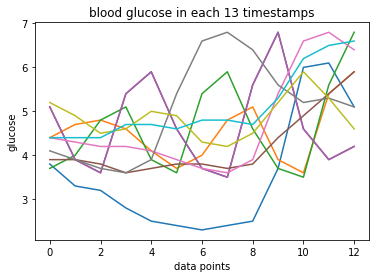

In [ ]:
#select columns with data from glucose in blood
gluc_datapoints=df_filt.to_numpy()
gluc_datapoints=gluc_datapoints[:, 15:]

measurements_to_plot=10# len(gluc_datapoints)
for i in range(measurements_to_plot):
  plt.plot(gluc_datapoints[i,:])
plt.xlabel("data points")
plt.ylabel("glucose")
plt.title("blood glucose in each 13 timestamps")
plt.show()

In [ ]:
gluc_resp_plot=np.array([2.23,0.92,2.32,1.31])
str(gluc_resp_plot[0])

'2.23'

### **Blood glucose measurements examples**

Text(0.5, 0.98, 'GC 4 subjects')

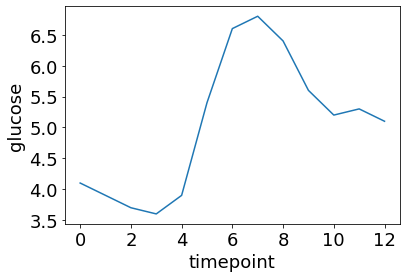

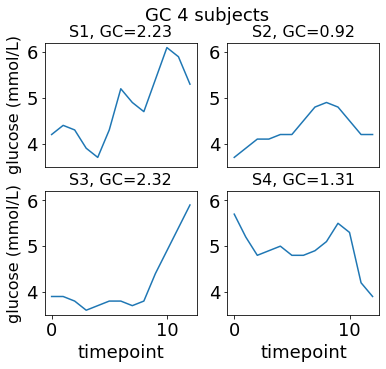

In [ ]:
plt.plot(gluc_datapoints[7,:])
plt.ylabel("glucose", fontsize=18)
plt.xlabel("timepoint", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

gluc_datapoints_interest=list([37,38,39,40,64,3,5,34])
gluc_datapoints_interest=list([37,38,5,64])

fig, axes = plt.subplots(2,2,figsize=(6, 5))
i=0
for ax in axes.flatten():
    numfig=gluc_datapoints_interest[i]
    ax.plot(gluc_datapoints[numfig,:])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    ax.set_ylim((3.5,6.2))
    #ax.title(f'{gluc_resp_plot[%f]}'%ax)
    #f"the gradient is {m}, the intercept is {c}"
   # ax.title("The gradient is {}, the intercept is".format(gluc_resp_plot[ax]))
    ax.set_title('S'+str(i+1)+", GC="+str(gluc_resp_plot[i]), fontsize=16)

    if (i==0) | (i==2):
      ax.set_ylabel("glucose (mmol/L)", fontsize=16)
    if (i==3) | (i==2):
      ax.set_xlabel("timepoint", fontsize=18)
    else:
      ax.tick_params(labelbottom=False) 
      ax.xaxis.set_ticks([])   

    i=i+1
plt.suptitle("GC 4 subjects", fontsize=18)

Glucose datapoints from different participants:

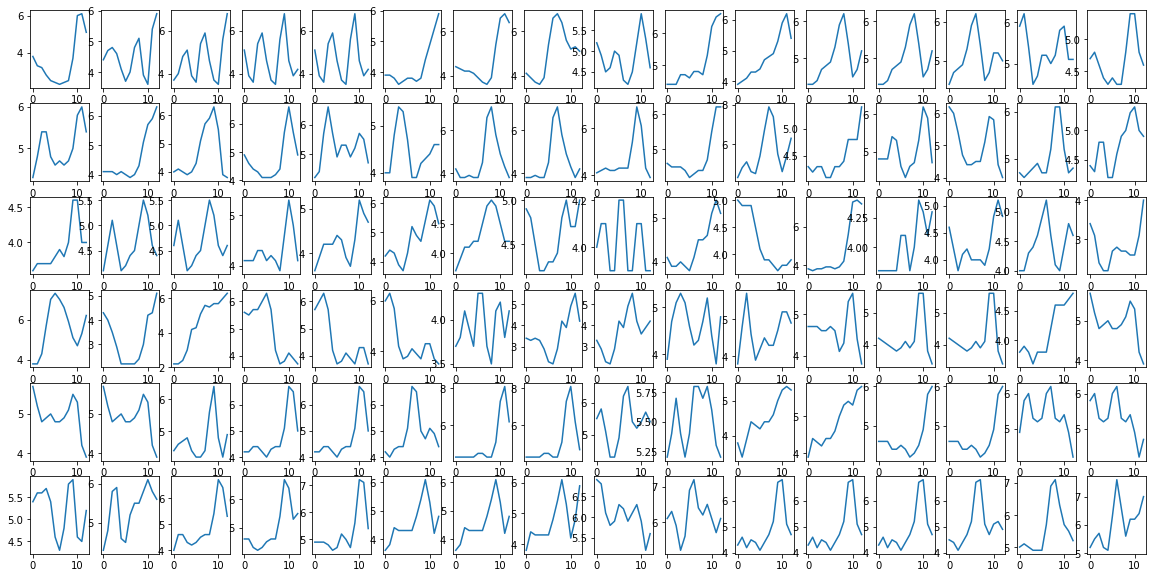

In [ ]:
measurements_to_subplot=16
fig, axes = plt.subplots(6,measurements_to_subplot,figsize=(20, 10))
i=0
for ax in axes.flatten():
    ax.plot(gluc_datapoints[i,:])
    i=i+1

We find at which timepoint the glucose peak is:

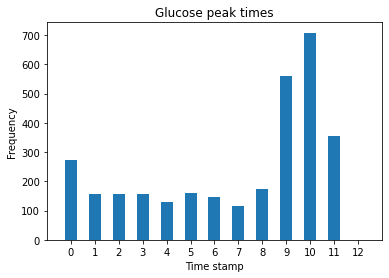

In [ ]:
peaks_glucose=np.argmax(gluc_datapoints,axis=1)
min_glucose=np.argmin(gluc_datapoints,axis=1)

#plt.hist(peaks_glucose)

bins = np.arange(13) - 0.5
plt.hist(peaks_glucose, bins,rwidth=0.5)
plt.xticks(range(13))
plt.xlim([-1, 13])
plt.ylabel("Frequency")
plt.xlabel("Time stamp")
plt.title("Glucose peak times")
plt.show()

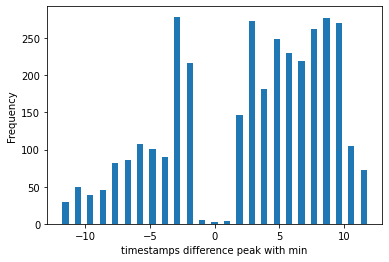

In [ ]:
bins=25
dif_peak_min=peaks_glucose-min_glucose
plt.hist(dif_peak_min,bins,rwidth=0.5)
plt.ylabel("Frequency")
plt.xlabel("timestamps difference peak with min")
plt.show()

In [ ]:
weird=((dif_peak_min < 0) & (peaks_glucose<3))
df_filt[weird]# observations with the peak before the min and where the peak is before timestamp -4

,Folder,Filename,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4
14,327,IMG_20190310_143914.jpg,-116.0,-101.0,-86.0,-71.0,-56.0,-41.0,-26.0,-11.0,4.0,19.0,34.0,49.0,64.0,5.9,6.2,5.4,4.5,4.7,5.2,5.2,5.0,5.2,5.8,5.9,5.1,5.1
29,327,IMG_20190314_183118.jpg,-123.0,-108.0,-93.0,-78.0,-63.0,-48.0,-33.0,-18.0,-3.0,12.0,27.0,42.0,57.0,6.2,6.0,5.4,4.7,4.4,4.4,4.5,4.5,5.1,5.9,5.8,4.4,4.0
47,236,14_4/IMG_20180414_172226.jpg,-120.0,-105.0,-90.0,-75.0,-60.0,-45.0,-30.0,-15.0,0.0,15.0,30.0,45.0,60.0,5.0,4.9,4.9,4.9,4.5,4.1,3.9,3.9,3.8,3.7,3.8,3.8,3.9
57,203,IMG_5804.JPG,-125.0,-110.0,-95.0,-80.0,-65.0,-50.0,-35.0,-20.0,-5.0,10.0,25.0,40.0,55.0,5.7,6.0,6.3,5.7,4.2,3.7,3.8,4.1,3.9,3.7,4.3,4.3,3.7
58,203,IMG_5805.JPG,-117.0,-102.0,-87.0,-72.0,-57.0,-42.0,-27.0,-12.0,3.0,18.0,33.0,48.0,63.0,6.0,6.3,5.7,4.2,3.7,3.8,4.1,3.9,3.7,4.3,4.3,3.7,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,33,IMG_2414.HEIC,-121.0,-106.0,-91.0,-76.0,-61.0,-46.0,-31.0,-16.0,-1.0,14.0,29.0,44.0,59.0,3.8,4.7,4.5,3.6,3.1,2.4,2.6,2.4,2.2,2.2,3.2,4.7,3.2
3898,33,IMG_2424.HEIC,-118.0,-103.0,-88.0,-73.0,-58.0,-43.0,-28.0,-13.0,2.0,17.0,32.0,47.0,62.0,7.4,7.5,5.6,4.8,4.3,3.7,3.5,3.8,4.3,4.9,4.8,4.1,3.9
3902,33,IMG_2447.HEIC,-114.0,-99.0,-84.0,-69.0,-54.0,-39.0,-24.0,-9.0,6.0,21.0,36.0,51.0,66.0,8.0,8.8,8.6,7.5,6.5,6.1,5.7,5.4,5.1,5.3,6.1,6.7,6.4
3905,33,IMG_2475.HEIC,-118.0,-103.0,-88.0,-73.0,-58.0,-43.0,-28.0,-13.0,2.0,17.0,32.0,47.0,62.0,5.1,5.0,4.9,4.9,5.0,4.9,4.9,4.9,4.9,5.1,5.1,4.9,5.0


In [ ]:
df.Folder.unique()

array([327, 236, 203,  69, 106, 249,  68,  15, 300, 212,  77,  45, 251,
       121, 164, 132, 233,  80, 240,  56, 134, 225, 159, 214, 215,  43,
       317,  81, 230, 285,   5, 290, 171, 330,  90, 118, 209, 153,  67,
       120, 274, 147, 220, 221,  60, 139, 332, 116, 128, 269,  21,  55,
       280, 260, 338, 208,  72, 261,  17,  89, 286, 182, 314, 146, 126,
       243, 205, 204, 190, 252, 289, 272, 303,  13, 183,  27, 100, 255,
       175,  95,  94, 172, 218, 228, 117, 234, 211, 219, 263,  71,  76,
        65,  63, 231,  26,   9, 271, 169, 185, 187, 237, 162, 186, 157,
       158, 267,  79,  42, 264, 248, 109, 224,   8, 170,  50,  40,   3,
        29, 168, 336,  33, 112])

below we have each column summary:

In [ ]:
df_filt.describe()

,Folder,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4
count,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3412.000000,3409.000000,3405.000000,3401.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3412.000000,3409.000000,3405.000000,3401.000000
mean,163.485681,-120.219170,-105.220923,-90.219170,-75.220923,-60.219170,-45.220923,-30.219170,-15.207773,-0.206020,14.862251,29.877383,44.872247,59.887092,4.767329,4.757510,4.756663,4.769784,4.775102,4.782817,4.788428,4.816803,5.040707,5.457122,5.575037,5.324229,5.148280
std,96.296551,4.763069,4.761883,4.763069,4.761883,4.763069,4.761883,4.763069,4.743564,4.744749,4.318229,4.359866,4.357599,4.412704,1.054175,1.049511,1.048235,1.046350,1.036958,1.032114,1.012711,0.992153,1.052762,1.189450,1.240734,1.169947,1.084418
min,3.000000,-176.000000,-161.000000,-146.000000,-131.000000,-116.000000,-101.000000,-86.000000,-71.000000,-56.000000,8.000000,22.000000,38.000000,52.000000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000
25%,77.000000,-124.000000,-109.000000,-94.000000,-79.000000,-64.000000,-49.000000,-34.000000,-19.000000,-4.000000,11.000000,26.000000,41.000000,56.000000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.300000,4.700000,4.700000,4.600000,4.400000
50%,147.000000,-120.000000,-105.000000,-90.000000,-75.000000,-60.000000,-45.000000,-30.000000,-15.000000,0.000000,15.000000,30.000000,45.000000,60.000000,4.700000,4.700000,4.700000,4.700000,4.700000,4.700000,4.700000,4.700000,5.000000,5.400000,5.400000,5.200000,5.000000
75%,240.000000,-116.000000,-101.000000,-86.000000,-71.000000,-56.000000,-41.000000,-26.000000,-11.000000,4.000000,19.000000,34.000000,49.000000,64.000000,5.300000,5.300000,5.300000,5.300000,5.300000,5.300000,5.300000,5.400000,5.700000,6.100000,6.300000,6.000000,5.800000
max,338.000000,-113.000000,-98.000000,-83.000000,-68.000000,-53.000000,-38.000000,-23.000000,-8.000000,7.000000,22.000000,52.000000,67.000000,101.000000,12.300000,12.300000,10.900000,10.200000,10.900000,10.900000,12.300000,10.800000,11.000000,11.600000,11.800000,11.800000,11.800000


In [ ]:
n_patients_w_gluc=len(pd.unique(df_filt["Folder"]))
patients_w_gluc=sorted(pd.unique(df_filt["Folder"]))
print("number of patients with images and blood glucose measured:",n_patients_w_gluc)

number of patients with images and blood glucose measured: 117


In [ ]:
#peak values
peaks_glucose_values=np.max(gluc_datapoints,axis=1)
df_filt["peaks_glucose_values"]=peaks_glucose_values


df_filt_gluc=df_filt[["glucose_mmol_L_pt -8","glucose_mmol_L_pt -7","glucose_mmol_L_pt -6","glucose_mmol_L_pt -5","glucose_mmol_L_pt -4",
            "glucose_mmol_L_pt -3","glucose_mmol_L_pt -2","glucose_mmol_L_pt -1","glucose_mmol_L_pt 0","glucose_mmol_L_pt 1","glucose_mmol_L_pt 2",
            "glucose_mmol_L_pt 3","glucose_mmol_L_pt 4",]]
#df_filt_gluc=df_filt_gluc.fillna(1000)
import heapq
smallest = df_filt_gluc.apply(lambda x: heapq.nsmallest(3, x), axis=1)
smallest=np.vstack(smallest)
df_filt["3lowest_glucose_values"]=np.mean(smallest,axis=1)
df_filt["3lowest_glucose_values"]=np.mean(smallest,axis=1)
df_filt["change_peak_w_lowest"]=df_filt["peaks_glucose_values"]-df_filt["3lowest_glucose_values"]
df_filt

,Folder,Filename,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4,peaks_glucose_values,3lowest_glucose_values,change_peak_w_lowest
0,327,IMG_20190307_130615.jpg,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,3.8,3.3,3.2,2.8,2.5,2.4,2.3,2.4,2.5,3.7,6.0,6.1,5.1,6.1,2.366667,3.73333
1,327,IMG_20190307_192048.jpg,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,4.4,4.7,4.8,4.6,4.1,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,5.9,3.733333,2.16667
2,327,IMG_20190307_204505.jpg,-122.0,-107.0,-92.0,-77.0,-62.0,-47.0,-32.0,-17.0,-2.0,13.0,28.0,43.0,58.0,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,6.8,3.600000,3.2
3,327,IMG_20190307_213128.jpg,-123.0,-108.0,-93.0,-78.0,-63.0,-48.0,-33.0,-18.0,-3.0,12.0,27.0,42.0,57.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2,6.8,3.600000,3.2
4,327,IMG_20190307_213224.jpg,-124.0,-109.0,-94.0,-79.0,-64.0,-49.0,-34.0,-19.0,-4.0,11.0,26.0,41.0,56.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2,6.8,3.600000,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,112,IMG_3387.HEIC,-120.0,-105.0,-90.0,-75.0,-60.0,-45.0,-30.0,-15.0,0.0,15.0,30.0,45.0,60.0,5.6,4.8,5.0,5.6,5.7,5.6,5.3,4.7,4.8,5.1,5.4,5.6,5.6,5.7,4.766667,0.933333
3914,112,IMG_3388.HEIC,-126.0,-111.0,-96.0,-81.0,-66.0,-51.0,-36.0,-21.0,-6.0,9.0,24.0,39.0,54.0,4.1,4.1,4.1,4.2,4.3,4.4,4.3,4.3,4.4,4.6,4.6,4.5,4.5,4.6,4.100000,0.5
3915,112,IMG_3390.HEIC,-121.0,-106.0,-91.0,-76.0,-61.0,-46.0,-31.0,-16.0,-1.0,14.0,29.0,44.0,59.0,4.3,4.3,4.4,4.6,4.6,4.5,4.5,4.8,5.2,5.0,4.3,4.3,5.2,5.2,4.300000,0.9
3916,112,IMG_3391.HEIC,-117.0,-102.0,-87.0,-72.0,-57.0,-42.0,-27.0,-12.0,3.0,18.0,33.0,48.0,63.0,5.1,4.3,3.8,4.5,4.8,4.7,4.9,5.3,5.3,5.1,4.8,4.8,5.8,5.8,4.200000,1.6


## **Load raw images**

In [ ]:
from os import listdir
from matplotlib import image
from skimage.transform import resize
import cv2
drive_path = 'drive/MyDrive/DTU/DeepLearning/Deep_learning_Project/data/' #if working in mac, write gdrive instead of drive

#convert list of ints of patients to string to be read by the image loading:
list_patients_w_gluc=[str(x) for x in patients_w_gluc]

# load all images in a directory
loaded_images = list()
images_filename=[]
list_patients = list_patients_w_gluc[5:80]#["68","303"] # # list_patients_w_gluc[10:15]
size_images=64


for patient in list_patients:
  print(patient)
  for filename in listdir(drive_path+patient+'/'):
    # load image
  # img_data = image.imread(drive_path+'68/'+filename)
    image_cv2 = cv2.imread(drive_path+patient+'/'+filename)
    new_image = resize(image_cv2, output_shape=(size_images, size_images), mode='reflect', anti_aliasing=True)
  #  new_image = image_cv2.resize((32, 32))

    # store loaded image
    #img_data
    #img_data_flat = img_data.flatten()
    loaded_images.append(new_image)
    images_filename.append(filename+"_"+patient)

    #print('> loaded %s %s' % (filename, img_data.shape))

print("loaded images: ", len(loaded_images))
print("loaded images filenames: ", images_filename)

## **Load segmented images**

In [ ]:
drive_path_segmented = 'drive/MyDrive/DTU/DeepLearning/Deep_learning_Project/segmentation_data/segmented_images/COPSAC_segmented/' #if working in mac, write gdrive instead of drive

# load all images in a directory
loaded_images_segmented = list()
images_filename_segmented=[]

for patient in list_patients:
  print(patient)
  for filename in listdir(drive_path_segmented+patient+'/'):
    # load image
  # img_data = image.imread(drive_path+'68/'+filename)
    image_cv2 = cv2.imread(drive_path_segmented+patient+'/'+filename)
    new_image = resize(image_cv2, output_shape=(size_images, size_images), mode='reflect', anti_aliasing=True)
  #  new_image = image_cv2.resize((32, 32))

    # store loaded image
    #img_data
    #img_data_flat = img_data.flatten()
    loaded_images_segmented.append(new_image)
    images_filename_segmented.append(filename+"_"+patient)

    #print('> loaded %s %s' % (filename, img_data.shape))

print("loaded images segmented: ", len(loaded_images_segmented))
print("loaded images segmented filenames: ", images_filename_segmented)

In [ ]:
#rename image filenames in df* with glucose data
for idx, row in df_filt.iterrows():
        df_filt.loc[idx,'Filename'] = str(df_filt[["Filename"]].loc[idx][0])+ "_"+str(df_filt[["Folder"]].loc[idx][0])

In [ ]:
df_filt.dropna(axis='rows')

,Folder,Filename,reltime_min_-8,reltime_min_-7,reltime_min_-6,reltime_min_-5,reltime_min_-4,reltime_min_-3,reltime_min_-2,reltime_min_-1,reltime_min_0,reltime_min_1,reltime_min_2,reltime_min_3,reltime_min_4,glucose_mmol_L_pt -8,glucose_mmol_L_pt -7,glucose_mmol_L_pt -6,glucose_mmol_L_pt -5,glucose_mmol_L_pt -4,glucose_mmol_L_pt -3,glucose_mmol_L_pt -2,glucose_mmol_L_pt -1,glucose_mmol_L_pt 0,glucose_mmol_L_pt 1,glucose_mmol_L_pt 2,glucose_mmol_L_pt 3,glucose_mmol_L_pt 4,peaks_glucose_values,3lowest_glucose_values,change_peak_w_lowest
0,327,IMG_20190307_130615.jpg_327,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,3.8,3.3,3.2,2.8,2.5,2.4,2.3,2.4,2.5,3.7,6.0,6.1,5.1,6.1,2.366667,3.73333
1,327,IMG_20190307_192048.jpg_327,-113.0,-98.0,-83.0,-68.0,-53.0,-38.0,-23.0,-8.0,7.0,22.0,37.0,52.0,67.0,4.4,4.7,4.8,4.6,4.1,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,5.9,3.733333,2.16667
2,327,IMG_20190307_204505.jpg_327,-122.0,-107.0,-92.0,-77.0,-62.0,-47.0,-32.0,-17.0,-2.0,13.0,28.0,43.0,58.0,3.7,4.0,4.8,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,6.8,3.600000,3.2
3,327,IMG_20190307_213128.jpg_327,-123.0,-108.0,-93.0,-78.0,-63.0,-48.0,-33.0,-18.0,-3.0,12.0,27.0,42.0,57.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2,6.8,3.600000,3.2
4,327,IMG_20190307_213224.jpg_327,-124.0,-109.0,-94.0,-79.0,-64.0,-49.0,-34.0,-19.0,-4.0,11.0,26.0,41.0,56.0,5.1,3.9,3.6,5.4,5.9,4.6,3.7,3.5,5.6,6.8,4.6,3.9,4.2,6.8,3.600000,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,112,IMG_3387.HEIC_112,-120.0,-105.0,-90.0,-75.0,-60.0,-45.0,-30.0,-15.0,0.0,15.0,30.0,45.0,60.0,5.6,4.8,5.0,5.6,5.7,5.6,5.3,4.7,4.8,5.1,5.4,5.6,5.6,5.7,4.766667,0.933333
3914,112,IMG_3388.HEIC_112,-126.0,-111.0,-96.0,-81.0,-66.0,-51.0,-36.0,-21.0,-6.0,9.0,24.0,39.0,54.0,4.1,4.1,4.1,4.2,4.3,4.4,4.3,4.3,4.4,4.6,4.6,4.5,4.5,4.6,4.100000,0.5
3915,112,IMG_3390.HEIC_112,-121.0,-106.0,-91.0,-76.0,-61.0,-46.0,-31.0,-16.0,-1.0,14.0,29.0,44.0,59.0,4.3,4.3,4.4,4.6,4.6,4.5,4.5,4.8,5.2,5.0,4.3,4.3,5.2,5.2,4.300000,0.9
3916,112,IMG_3391.HEIC_112,-117.0,-102.0,-87.0,-72.0,-57.0,-42.0,-27.0,-12.0,3.0,18.0,33.0,48.0,63.0,5.1,4.3,3.8,4.5,4.8,4.7,4.9,5.3,5.3,5.1,4.8,4.8,5.8,5.8,4.200000,1.6


We have 1884 images with glucose measurements information, before checking how many of them were actually loaded.

In [ ]:
#take rows of glucose data from the images loaded.
data_patients_with_blood=df_filt[df_filt['Filename'].isin(images_filename)].reset_index()
y_df=data_patients_with_blood[['Filename',"change_peak_w_lowest"]]
print("Glucose change images patient loaded:")
y_df

Glucose change images patient loaded:


,Filename,change_peak_w_lowest
0,IMG_5775.JPG_203,2.9
1,IMG_5782.JPG_203,4.03333
2,IMG_5801.JPG_203,2.56667
3,IMG_5804.JPG_203,2.6
4,IMG_5805.JPG_203,2.66667
...,...,...
1879,IMG_3533.JPG_26,1.86667
1880,IMG_3534.JPG_26,1.86667
1881,IMG_3535.JPG_26,1.86667
1882,IMG_3537.JPG_26,2.76667


In [ ]:
y_df.isna().sum() 

Filename                0
change_peak_w_lowest    7
dtype: int64

In [ ]:
len(y_df)

1884

We have 1844 images loaded with glucose measurements.

In [ ]:
boolean = data_patients_with_blood.duplicated(subset=['Filename']).any() # True
boolean

False

In [ ]:
#list of images ID with glucose data
list_images_w_gluc=data_patients_with_blood["Filename"].unique().tolist()
len(list_images_w_gluc)

1884

In [ ]:
#from all the loaded images....
loaded_images_array=np.stack(loaded_images, axis=0 )#images are stack to create a matrix of images
np.shape(loaded_images_array)

(3801, 64, 64, 3)

In [ ]:
#from all the segmented images loaded....
loaded_images_segmented_array=np.stack(loaded_images_segmented, axis=0 )#images are stack to create a matrix of images
np.shape(loaded_images_segmented_array)

(3705, 64, 64, 3)

In [ ]:
#we select only the ones with blood glucose measurements
# using list comprehension and enumerate()
# Get match indices
images_w_gluc_idx = [key for key, val in enumerate(images_filename)
                      if val in set(list_images_w_gluc)]

s_images_w_gluc_idx = [key for key, val in enumerate(images_filename_segmented)
                      if val in set(list_images_w_gluc)]


loaded_images_w_gluc=loaded_images_array[images_w_gluc_idx,:,:,:]
loaded_segmented_images_w_gluc=loaded_images_segmented_array[s_images_w_gluc_idx,:,:,:]

np.shape(loaded_segmented_images_w_gluc)

(1884, 64, 64, 3)

In [ ]:
#vector with glucose data change, to be the response variable
y=y_df["change_peak_w_lowest"].to_numpy()

In [ ]:
idx_nan_gluc=y_df[y_df['change_peak_w_lowest'].isnull()].index.tolist()
idx_nan_gluc

[606, 880, 1135, 1504, 1612, 1613, 1614]

Delete images and response variables that are nans:

In [ ]:
y = np.delete(y, idx_nan_gluc,axis=0)
loaded_images_w_gluc = np.delete(loaded_images_w_gluc, idx_nan_gluc,axis=0)
loaded_segmented_images_w_gluc = np.delete(loaded_segmented_images_w_gluc, idx_nan_gluc,axis=0)


In [ ]:
np.shape(loaded_images_w_gluc)

(1877, 64, 64, 3)

In [ ]:
np.shape(loaded_segmented_images_w_gluc)

(1877, 64, 64, 3)

Compute mean Glucose Change over all images with glucose data:

In [ ]:
y_mean=np.mean(y)*np.ones(len(y))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

Train and test splits:

In [ ]:
from torch.utils.data import DataLoader

# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(loaded_images_w_gluc, y,test_size=0.2, random_state=1)

s_X_train, s_X_test,y_train,y_test = train_test_split(loaded_segmented_images_w_gluc, y,test_size=0.2, random_state=1)

In [ ]:
trainset = []
for i in range(len(X_train)):
   trainset.append([X_train[i], y_train[i]])

testset = []
for i in range(len(X_test)):
   testset.append([X_test[i], y_test[i]])

trainset_segmented = []
for i in range(len(s_X_train)):
   trainset_segmented.append([s_X_train[i], y_train[i]])

testset_segmented = []
for i in range(len(s_X_test)):
   testset_segmented.append([s_X_test[i], y_test[i]])

Numpy to Tensors:

In [ ]:
batch_size = 128#np.int(len(trainset)/2)
eval_batch_size = 64#np.int(len(testset)/2)

# The loaders perform the actual work
train_loader = DataLoader(trainset, batch_size=batch_size) #,sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(testset, batch_size=eval_batch_size) #,sampler=stratified_sampler(dset_test.test_labels))
train_loader_segmented = DataLoader(trainset_segmented, batch_size=batch_size) #,sampler=stratified_sampler(dset_train.train_labels))
test_loader_segmented  = DataLoader(testset_segmented, batch_size=eval_batch_size) #,sampler=stratified_sampler(dset_test.test_labels))

In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x,y = next(iter(train_loader))
print("Batch dimension [B x C x H x W]:", x.shape)

print("\n# Test data")
print("Number of points:", len(testset))
x,y = next(iter(test_loader))
print("Batch dimension [B x C x H x W]:", x.shape)

# Training data
Number of points: 1501
Batch dimension [B x C x H x W]: torch.Size([128, 64, 64, 3])

# Test data
Number of points: 376
Batch dimension [B x C x H x W]: torch.Size([64, 64, 64, 3])


In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

## **The CNN is defined:**

In [ ]:

#new version
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

channels = 3#trainset.Data.shape[3]
width = size_images #trainset.Data.shape[2]
height = size_images  #trainset.Data.shape[1]

# 1st convolutional layer initialization
kernel_size_conv1 = 5 # [height, width]
num_filters_conv1 = 64
stride_conv1 = 2
padding_conv1 = 1 

# Maxpool layer initialization
#kernel_size_pool = 
#stride_pool = 2
#padding_pool = 0

# 2nd convolutional layer initialization
kernel_size_conv2 = 4 # [height, width]
num_filters_conv2 = 32
stride_conv2 = 1
padding_conv2 = 1 

kernel_size_conv3 = 3 # [height, width]
num_filters_conv3 = 16
stride_conv3 = 1
padding_conv3 = 1 

kernel_size_conv4 = 3 # [height, width]
num_filters_conv4 = 8
stride_conv4 = 1
padding_conv4 = 1 

# Number of units in dense layer  
num_l1 = 500

def compute_conv_dim_1(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.num_classes = 1    
      # Convolutional layer
      self.conv_1 = nn.Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1, padding = padding_conv1)

      torch.nn.BatchNorm2d(num_filters_conv1)  
      self.conv_1_out_height = compute_conv_dim_1(height,kernel_size_conv1,padding_conv1,stride_conv1)
      self.conv_1_out_width = compute_conv_dim_1(width,kernel_size_conv1,padding_conv1,stride_conv1)

      # Maxpooling layer
      #self.pool = torch.nn.MaxPool2d(kernel_size=kernel_size_pool,
      #                       stride=stride_pool, padding=padding_pool)
        

      #self.pool_out_height = compute_conv_dim_1(self.conv_1_out_height,kernel_size_pool,padding_pool,stride_pool)
      #self.pool_out_width = compute_conv_dim_1(self.conv_1_out_width,kernel_size_pool,padding_pool,stride_pool)
        
        # 2nd Convolutional layer
      self.conv_2 = nn.Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2, padding = padding_conv2)

      torch.nn.BatchNorm2d(num_filters_conv2)  
      self.conv_2_out_height = compute_conv_dim_1(self.conv_1_out_height,kernel_size_conv2,padding_conv2,stride_conv2)
      self.conv_2_out_width = compute_conv_dim_1(self.conv_1_out_width,kernel_size_conv2,padding_conv2,stride_conv2)
        
        # 3rd Convolutional layer
      self.conv_3 = nn.Conv2d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3, padding = padding_conv3)

      torch.nn.BatchNorm2d(num_filters_conv3)  
      self.conv_3_out_height = compute_conv_dim_1(self.conv_2_out_height,kernel_size_conv3,padding_conv3,stride_conv3)
      self.conv_3_out_width = compute_conv_dim_1(self.conv_2_out_width,kernel_size_conv3,padding_conv3,stride_conv3)

        # 4th Convolutional layer
      self.conv_4 = nn.Conv2d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4, padding = padding_conv4)
      
      self.conv_4_out_height = compute_conv_dim_1(self.conv_3_out_height,kernel_size_conv4,padding_conv4,stride_conv4)
      self.conv_4_out_width = compute_conv_dim_1(self.conv_3_out_width,kernel_size_conv4,padding_conv4,stride_conv4)

        # add dropout to network
      self.dropout = nn.Dropout2d(p=0.25)
        
      self.l1_in_features = num_filters_conv3 * self.conv_3_out_height * self.conv_3_out_width
      self.l2_in_features = num_filters_conv2 * self.conv_2_out_height * self.conv_2_out_width

        # self.l1_in_features = channels * height * width
        
      self.l_2 = nn.Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
      num_l2=100
      self.l_1 = nn.Linear(in_features=num_l1, 
                          out_features=num_l2,
                          bias=True)
      num_l3=20

      self.l_0 = nn.Linear(in_features=num_l2, 
                          out_features=num_l3,
                          bias=True)
      self.l_out = nn.Linear(in_features=num_l3, 
                            out_features=1,
                            bias=False)

        
    
    def forward(self, x):
      # We apply ReLU in each hidden layer
      x = relu(self.conv_1(x))
      x = relu(self.conv_2(x))
      x = relu(self.conv_3(x))
      x = x.view(-1, self.l1_in_features)
      x = self.dropout(relu(self.l_2(x))) 
      x = relu(self.l_1(x)) 
      x = relu(self.l_0(x)) 

      x = self.l_out(x)
      return x
    

net = Net().double()
#net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.25, inplace=False)
  (l_2): Linear(in_features=14400, out_features=500, bias=True)
  (l_1): Linear(in_features=500, out_features=100, bias=True)
  (l_0): Linear(in_features=100, out_features=20, bias=True)
  (l_out): Linear(in_features=20, out_features=1, bias=False)
)


Define Loss

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9, weight_decay = 1e-4)

## **Train the network**

In [ ]:
num_epoch = 15  # Your code here!
run_loss_epoch=[]
run_loss_epoch_baseline=[]

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_baseline=0.0
    for i, data  in enumerate(train_loader, 0):

        inputs, labels = data

        inputs=torch.swapaxes(inputs, 1, 3)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs) #forward
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        baseline_model_ouput=np.mean(labels.numpy())
        loss_baseline = criterion(Variable(torch.tensor(baseline_model_ouput)), labels)

        
        
        # print statistics
        running_loss += loss.data
        running_loss_baseline += loss_baseline.data

        if i % 5 == 4:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
    run_loss_epoch.append(running_loss)
    run_loss_epoch_baseline.append(running_loss_baseline)

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,     5] loss: 4.866
[1,    10] loss: 4.961


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,     5] loss: 4.588
[2,    10] loss: 4.615
[3,     5] loss: 4.165
[3,    10] loss: 4.021
[4,     5] loss: 2.783
[4,    10] loss: 1.602
[5,     5] loss: 1.228
[5,    10] loss: 1.182
[6,     5] loss: 0.960
[6,    10] loss: 1.089
[7,     5] loss: 0.927
[7,    10] loss: 1.043
[8,     5] loss: 0.913
[8,    10] loss: 1.032
[9,     5] loss: 0.906
[9,    10] loss: 1.028
[10,     5] loss: 0.902
[10,    10] loss: 1.026
[11,     5] loss: 0.899
[11,    10] loss: 1.021
[12,     5] loss: 0.898
[12,    10] loss: 1.020
[13,     5] loss: 0.894
[13,    10] loss: 1.017
[14,     5] loss: 0.896
[14,    10] loss: 1.018
[15,     5] loss: 0.895
[15,    10] loss: 1.017
Finished Training


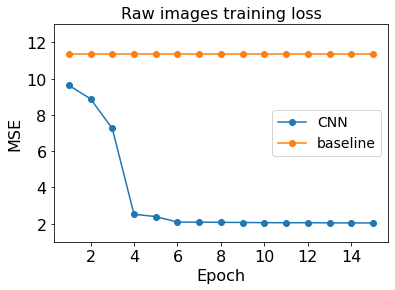

In [ ]:
plt.plot(np.arange(15)+1,run_loss_epoch,"-o",label="CNN")
plt.plot(np.arange(15)+1,run_loss_epoch_baseline,"-o",label="baseline")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("MSE",fontsize=16)
plt.legend(fontsize=14)
plt.ylim((1,13))
plt.title("Raw images training loss",fontsize=16)
plt.show()

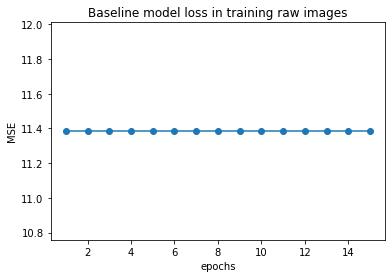

In [ ]:
plt.plot(np.arange(15)+1,run_loss_epoch_baseline,"-o")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("Baseline model loss in training raw images")
plt.show()

**Now with segmented images**

---



---



---



Network is restarted:

In [ ]:
#import torch.optim as optim
net2 = Net().double()
print(net2)
criterion = nn.MSELoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001,momentum=0.9, weight_decay = 1e-4)


Net(
  (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.25, inplace=False)
  (l_2): Linear(in_features=14400, out_features=500, bias=True)
  (l_1): Linear(in_features=500, out_features=100, bias=True)
  (l_0): Linear(in_features=100, out_features=20, bias=True)
  (l_out): Linear(in_features=20, out_features=1, bias=False)
)


Train network on the segmented images:

In [ ]:
num_epoch = 15  # Your code here!
s_run_loss_epoch=[]
s_run_loss_epoch_baseline=[]

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_baseline=0.0
    for i, data  in enumerate(train_loader_segmented, 0):
        inputs, labels = data

        inputs=torch.swapaxes(inputs, 1, 3)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net2(inputs) #forward
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        baseline_model_ouput=np.mean(labels.numpy())
        loss_baseline = criterion(Variable(torch.tensor(baseline_model_ouput)), labels)

        
        
        # print statistics
        running_loss += loss.data
        running_loss_baseline += loss_baseline.data

        if i % 5 == 4:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
    s_run_loss_epoch.append(running_loss)
    s_run_loss_epoch_baseline.append(running_loss_baseline)

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,     5] loss: 4.887
[1,    10] loss: 5.007


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,     5] loss: 4.701
[2,    10] loss: 4.791
[3,     5] loss: 4.450
[3,    10] loss: 4.439
[4,     5] loss: 3.720
[4,    10] loss: 2.712
[5,     5] loss: 1.529
[5,    10] loss: 1.590
[6,     5] loss: 1.080
[6,    10] loss: 1.101
[7,     5] loss: 0.954
[7,    10] loss: 1.071
[8,     5] loss: 0.923
[8,    10] loss: 1.035
[9,     5] loss: 0.901
[9,    10] loss: 1.022
[10,     5] loss: 0.898
[10,    10] loss: 1.015
[11,     5] loss: 0.897
[11,    10] loss: 1.015
[12,     5] loss: 0.896
[12,    10] loss: 1.017
[13,     5] loss: 0.893
[13,    10] loss: 1.015
[14,     5] loss: 0.893
[14,    10] loss: 1.014
[15,     5] loss: 0.894
[15,    10] loss: 1.013
Finished Training


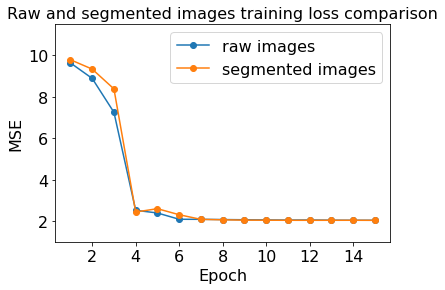

In [ ]:
plt.plot(np.arange(15)+1,run_loss_epoch,"-o",label="raw images")
plt.plot(np.arange(15)+1,s_run_loss_epoch,"-o",label="segmented images")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("MSE",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylim((1,11.5))
plt.title("Raw and segmented images training loss comparison",fontsize=16)
plt.show()

Text(0.5, 0.98, 'CNN loss in training')

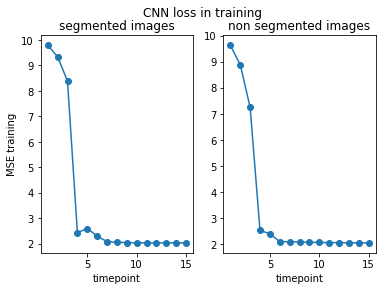

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(15)+1,s_run_loss_epoch,"-o")
ax1.set_title("segmented images")
ax2.plot(np.arange(15)+1,run_loss_epoch,"-o")
ax2.set_title("non segmented images")
ax2.set_xlabel("timepoint")
ax1.set_xlabel("timepoint")
ax1.set_ylabel("MSE training")

plt.suptitle("CNN loss in training")

## **TEST on the whole dataset, and their errors:**

In [ ]:
#net = Net().double()
error_batches = []
error_batches_s = []

error_batches_baseline = []

predicted_cnn=[]
label_truth=[]
predicted_cnn_s=[]
label_truth_s=[]
for data in test_loader:
    images, labels = data
    images=torch.swapaxes(images, 1, 3)

    outputs = net(Variable(images))

    predicted = outputs.data
    error=np.sqrt((labels.numpy()-np.ravel(predicted.numpy()))**2)
    y_test_mean=np.mean(labels.numpy())

    mean_error=np.mean(error)

    predicted_cnn.append(predicted.numpy())
    label_truth.append(labels.numpy())

    error_batches.append(np.array(mean_error))

for data in test_loader_segmented:
    images, labels = data
    images=torch.swapaxes(images, 1, 3)

    outputs = net2(Variable(images))

    predicted = outputs.data
    error=np.sqrt((labels.numpy()-np.ravel(predicted.numpy()))**2)
    y_test_mean=np.mean(labels.numpy())

    mean_error=np.mean(error)

    predicted_cnn_s.append(predicted.numpy())
    label_truth_s.append(labels.numpy())
    error_batches_s.append(np.array(mean_error))

print("Error in batch",error_batches_s)
print("Error in batch",error_batches)


Error in batch [array(0.55048284), array(0.80148806), array(0.65482394), array(0.59636111), array(0.76132715), array(0.82557067)]
Error in batch [array(0.5160424), array(0.83292088), array(0.67063537), array(0.60264064), array(0.76780874), array(0.83428983)]


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text major ticklabel objects>)

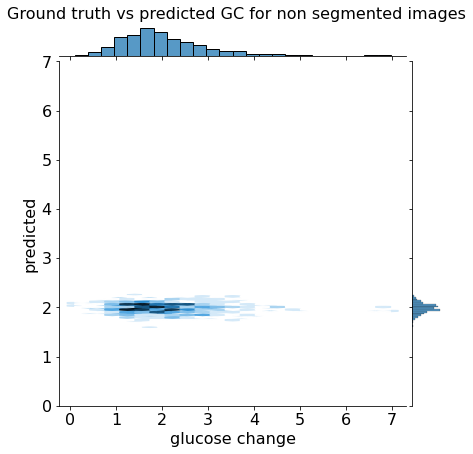

In [ ]:
#density plot of predicted and true values (seaborn) with scatter plot and desity function
import seaborn as sns
predicted_cnn_vec=np.vstack(predicted_cnn).reshape(-1)
label_truth_vec=np.concatenate(label_truth)

data = pd.DataFrame({"glucose change": label_truth_vec, "predicted": predicted_cnn_vec})
g = sns.jointplot(
    data=data,
    x="glucose change",y="predicted",
    kind="hex",
    ratio=10,ylim = (0,7)
)
g.set_axis_labels(xlabel="glucose change",ylabel="predicted",fontsize=16)
plt.suptitle("Ground truth vs predicted GC for non segmented images",y=1.02,fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


#plt.suptitle(title, y = 1)


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text major ticklabel objects>)

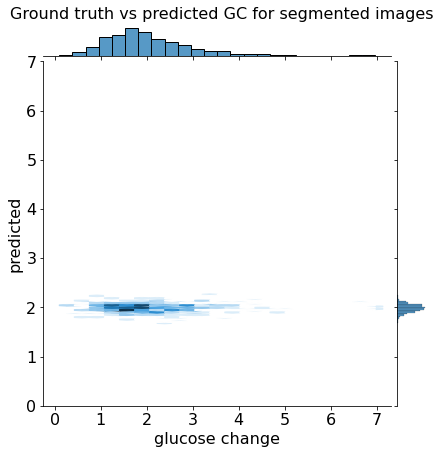

In [ ]:
predicted_cnn_vec_s=np.vstack(predicted_cnn_s).reshape(-1)
label_truth_vec_s=np.concatenate(label_truth_s)
#label_truth_vec=np.vstack(label_truth).reshape(-1)

data_s = pd.DataFrame({"glucose change": label_truth_vec_s, "predicted": predicted_cnn_vec_s})
g = sns.jointplot(
    data=data_s,
    x="glucose change",y="predicted",
    kind="hex",
    ratio=10,ylim = (0,7)
)
g.set_axis_labels(xlabel="glucose change",ylabel="predicted",fontsize=16)
plt.suptitle("Ground truth vs predicted GC for segmented images",y=1.02,fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)